# Convolutional Neural Networks (CNNs) in TensorFlow

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.

This tutorial is adapted from TensorFlow's [tutorial](https://www.tensorflow.org/tutorials/images/cnn), and the visualization portion adapted from a Kaggle [tutorial](https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn).

### Import TensorFlow

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

### Prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'), with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [3]:
print(type(train_images))

<class 'numpy.ndarray'>


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


In [4]:
print(train_images.ndim)
print(train_images.shape)
print(train_images.size)
print(len(train_images))
print(train_images[0:5,1,1,1])

4
(50000, 32, 32, 3)
153600000
50000
[0.         0.6        1.         0.11764706 0.7254902 ]


In [5]:
print(train_images[:1,:2,:4,])

[[[[0.23137255 0.24313725 0.24705882]
   [0.16862745 0.18039216 0.17647059]
   [0.19607843 0.18823529 0.16862745]
   [0.26666667 0.21176471 0.16470588]]

  [[0.0627451  0.07843137 0.07843137]
   [0.         0.         0.        ]
   [0.07058824 0.03137255 0.        ]
   [0.2        0.10588235 0.03137255]]]]


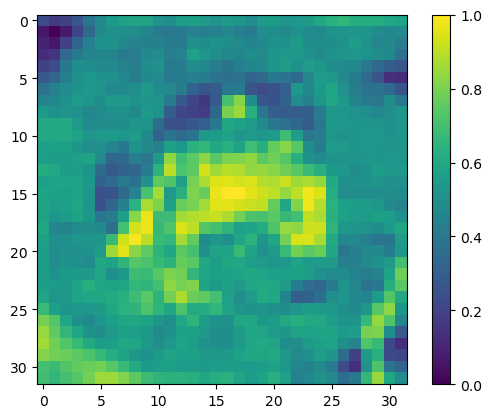

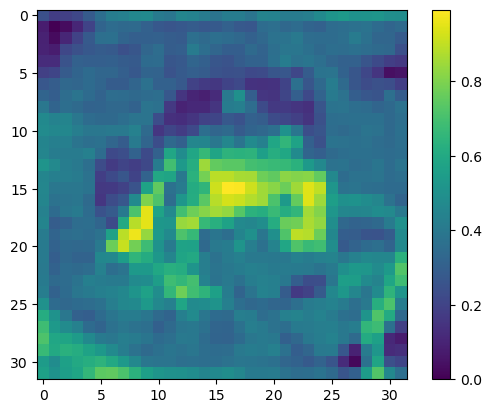

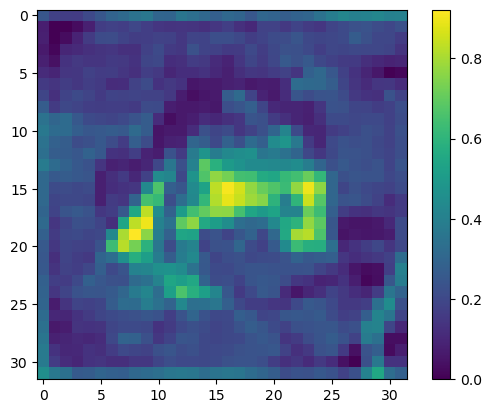

[6]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [12]:
plt.imshow(train_images[0,:,:,0]) # Channel R
plt.colorbar()
plt.show()

plt.imshow(train_images[0,:,:,1]) # Channel G
plt.colorbar()
plt.show()

plt.imshow(train_images[0,:,:,2]) # Channel B
plt.colorbar()
plt.show()

print(train_labels[0])
np.unique(train_labels)

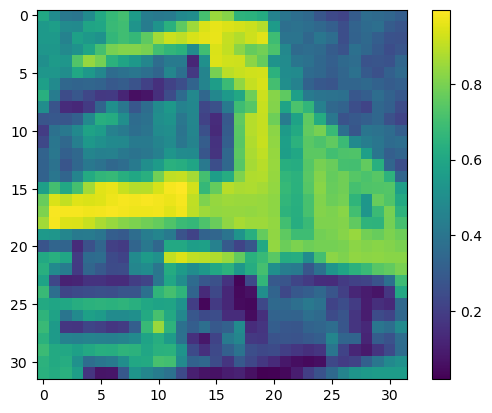

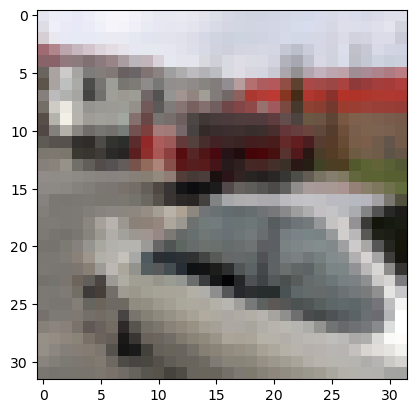

In [16]:
plt.imshow(train_images[1,:,:,0])
plt.colorbar()
plt.show()

plt.imshow(train_images[49999])

In [13]:
print(type(train_labels))
print(train_labels.ndim)
print(train_labels.shape)

<class 'numpy.ndarray'>
2
(50000, 1)


In [14]:
print(train_labels[0:10,])
# corresponds to the alphabetically-listed class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


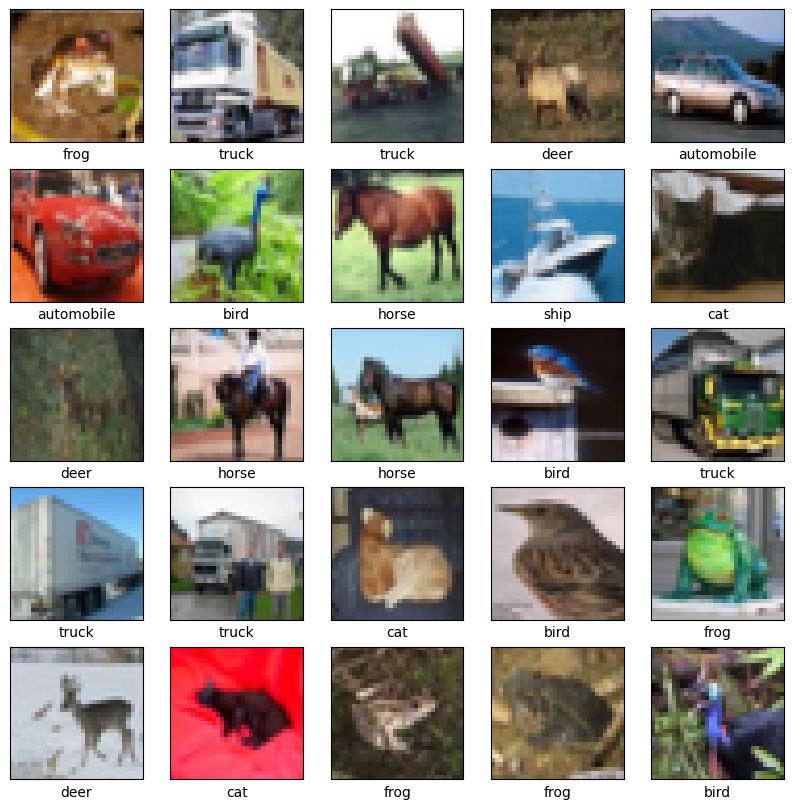

In [17]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [25]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (4 * 4 * 64 = 1024) before going through two Dense layers.

### Compile and train the model

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
   1/1563 [..............................] - ETA: 4:18 - loss: 2.2875 - accuracy: 0.0312

2023-12-01 12:38:47.927683: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1563/1563 [==============================] - 12s 8ms/step - loss: 1.5425 - accuracy: 0.4354 - val_loss: 1.2864 - val_accuracy: 0.5388
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1663 - accuracy: 0.5867 - val_loss: 1.1385 - val_accuracy: 0.6012
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0172 - accuracy: 0.6428 - val_loss: 0.9988 - val_accuracy: 0.6528
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9170 - accuracy: 0.6808 - val_loss: 0.9465 - val_accuracy: 0.6717
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8412 - accuracy: 0.7081 - val_loss: 0.9171 - val_accuracy: 0.6839
Epoch 6/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.7862 - accuracy: 0.7269 - val_loss: 0.9220 - val_accuracy: 0.6817
Epoch 7/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.7395 - accuracy: 0.7434 - val_loss: 0.8656 - val_accuracy: 0.7

### Evaluate the model

313/313 - 1s - loss: 0.9248 - accuracy: 0.6950 - 865ms/epoch - 3ms/step


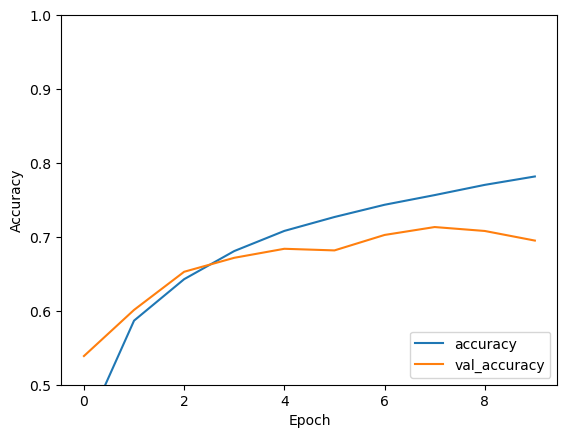

In [28]:
plt.plot(history.history['accuracy'], label='accuracy') # accuracy on the (subsampled at-this-epoch) training images
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # accuracy on the (other not-sampled-at-this-epoch) training images, i.e., cross-validation
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [29]:
print(test_acc)

0.6949999928474426


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.

In [30]:
prediction = model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [31]:
print(type(prediction))
print(prediction.ndim)
print(prediction.shape)
print(prediction[0,])
print(tf.nn.softmax(prediction[0,]))

<class 'numpy.ndarray'>
2
(10000, 10)
[-7.5079131e-01 -6.5082965e+00  4.3682344e-03  4.9365783e+00
 -3.7298977e+00  4.3577847e-01  4.1480899e+00 -4.7772112e+00
 -9.4334120e-01 -5.1015258e+00]
tf.Tensor(
[2.29058764e-03 7.23592530e-06 4.87425737e-03 6.75989628e-01
 1.16449395e-04 7.50356400e-03 3.07258487e-01 4.08596898e-05
 1.88939786e-03 2.95424725e-05], shape=(10,), dtype=float32)


In [32]:
score = tf.nn.softmax(prediction[0,])
cls_score = np.argmax(score)
print(score)
print(cls_score)
print(class_names[cls_score])

tf.Tensor(
[2.29058764e-03 7.23592530e-06 4.87425737e-03 6.75989628e-01
 1.16449395e-04 7.50356400e-03 3.07258487e-01 4.08596898e-05
 1.88939786e-03 2.95424725e-05], shape=(10,), dtype=float32)
3
cat


This image most likely belongs to cat with a 67.60 percent confidence.


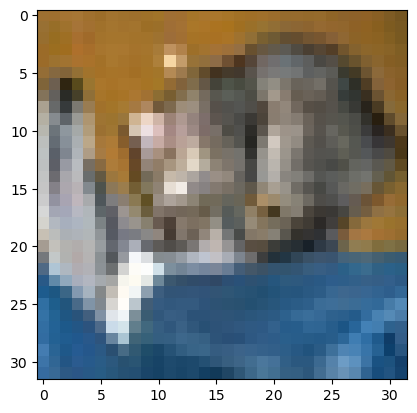

In [33]:
plt.imshow(test_images[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [34]:
score = tf.nn.softmax(prediction)

This image most likely belongs to dog with a 59.67 percent confidence.


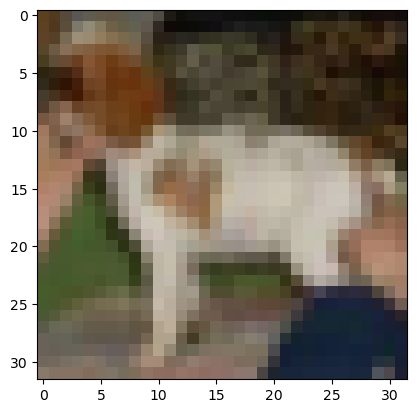

In [46]:
im = 12 # try 1,2,3

plt.imshow(test_images[im])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score[im,])], 100 * np.max(score[im,]))
)

### Visualizing the CNN filters

In [47]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_3 (3, 3, 3, 32)
conv2d_4 (3, 3, 32, 64)
conv2d_5 (3, 3, 64, 64)


Each layer has 3x3 filters; the input has 3 channels and outputs 32 channels; the first layer has 3x3 filters, takes in 32 channels and outputs 64; the last filter is still 3x3 and inputs/outputs 64 channels.

Get the first layer's filter:

In [48]:
filters , bias = model.layers[0].get_weights()

print(filters.shape)
print(bias.shape)

(3, 3, 3, 32)
(32,)


In [49]:
bias

array([-0.04678112,  0.02117817,  0.06159604, -0.04690548,  0.18231086,
        0.02446551, -0.00190216,  0.03982456, -0.00058925,  0.04338061,
        0.00045868, -0.02232406, -0.0366048 , -0.1294327 ,  0.04708232,
        0.01147479,  0.01885598, -0.08521758,  0.14405206,  0.08348067,
       -0.04114696, -0.03504481,  0.01786515, -0.21653992,  0.01136258,
        0.17052631, -0.30520484, -0.04246764,  0.007383  , -0.1464907 ,
        0.02961652, -0.01714117], dtype=float32)

For visualization purposes, normalize values to (0,1)

In [50]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

Look at the first 6 filters from the first layer

In [51]:
from matplotlib import pyplot

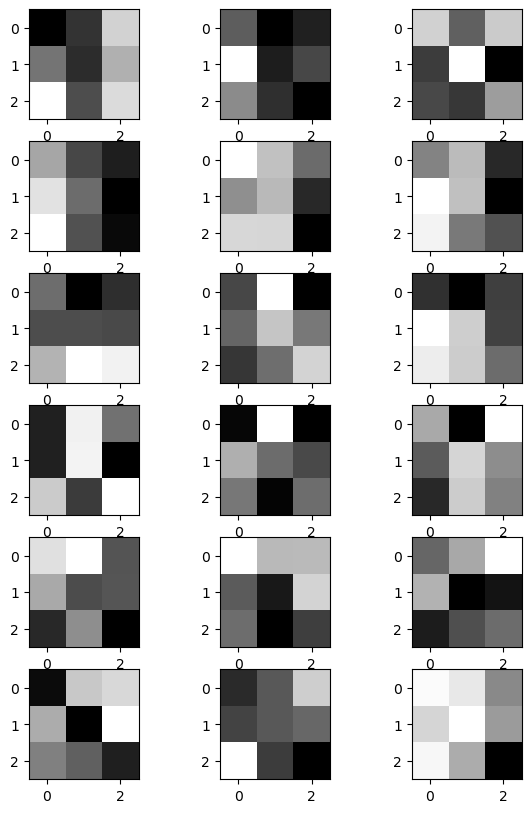

In [52]:
n_filters = 6
ix = 1
fig = pyplot.figure(figsize=(7,10))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        pyplot.subplot(n_filters,3,ix)
        pyplot.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
# plot the filters 
pyplot.show()

Each row is a separate set of filters for the 3 columns which are input channels.  Light colors are larger values.  For example, the first and third filters are:

In [53]:
print(filters[:,:,0,0])
print(filters[:,:,2,0])

[[0.32707298 0.403099   0.6392955 ]
 [0.49891272 0.39365596 0.5879647 ]
 [0.7059724  0.4411589  0.6519422 ]]
[[0.6469612  0.46969652 0.63656235]
 [0.414166   0.7192827  0.31795323]
 [0.43093395 0.40545154 0.5647345 ]]


It can be difficult to get a sense for what each individual filter is doing due to the sheer number of them; instead we can visualize the effect of each filter on the images themselves.  To do this we should keep track of the output dimension from each layer.

### Visualizing the features after convolution

In [54]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d_3 (None, 30, 30, 32)
2 conv2d_4 (None, 13, 13, 64)
4 conv2d_5 (None, 4, 4, 64)


Note in the above these are the layers after the max-pooling, that is what gets passed to the next layer.

One way to visualize the effect at each layer is to create a new model whose output will be the activation of a given layer's feature map; for example let's look at the first layer's effect.

In [55]:
from tensorflow.keras.models import Model

model2 = Model(inputs=model.inputs , outputs=model.layers[0].output)

prediction2 = model2.predict(test_images)

prediction2.shape

313/313 [==============================] - 0s 992us/step


(10000, 30, 30, 32)

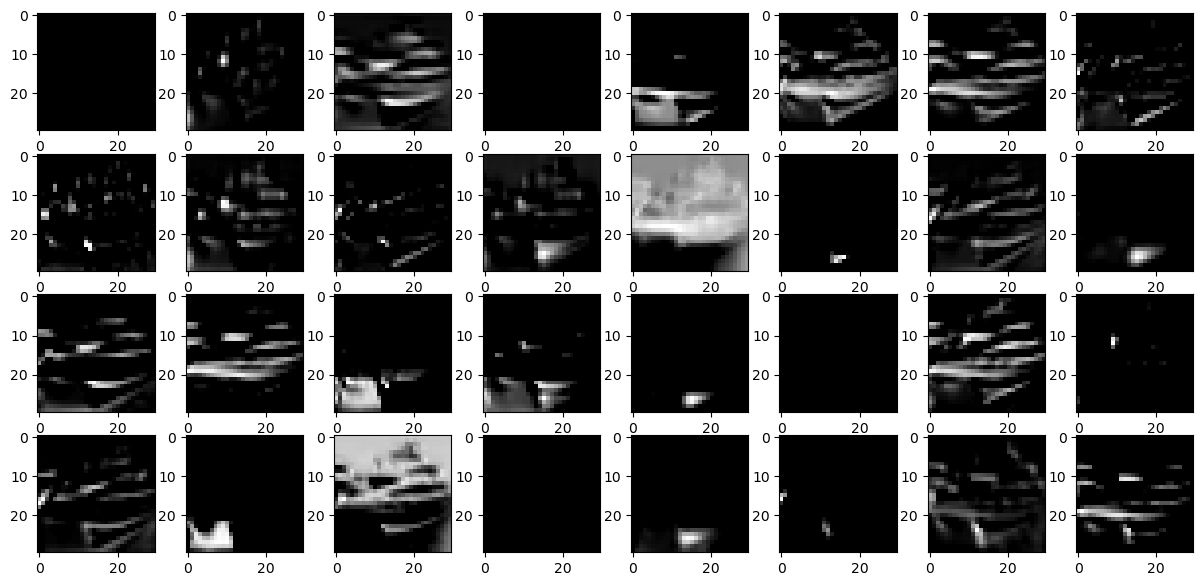

In [56]:
fig = pyplot.figure(figsize=(15,7))
for i in range(1,prediction2.shape[3]+1):

    pyplot.subplot(4,8,i)
    pyplot.imshow(prediction2[1,:,:,i-1] , cmap='gray')
    
pyplot.show()

For the next layer after max-pooling.

In [57]:
model2 = Model(inputs=model.inputs , outputs=model.layers[2].output)
prediction2 = model2.predict(test_images)
prediction2.shape

313/313 [==============================] - 1s 2ms/step


(10000, 13, 13, 64)

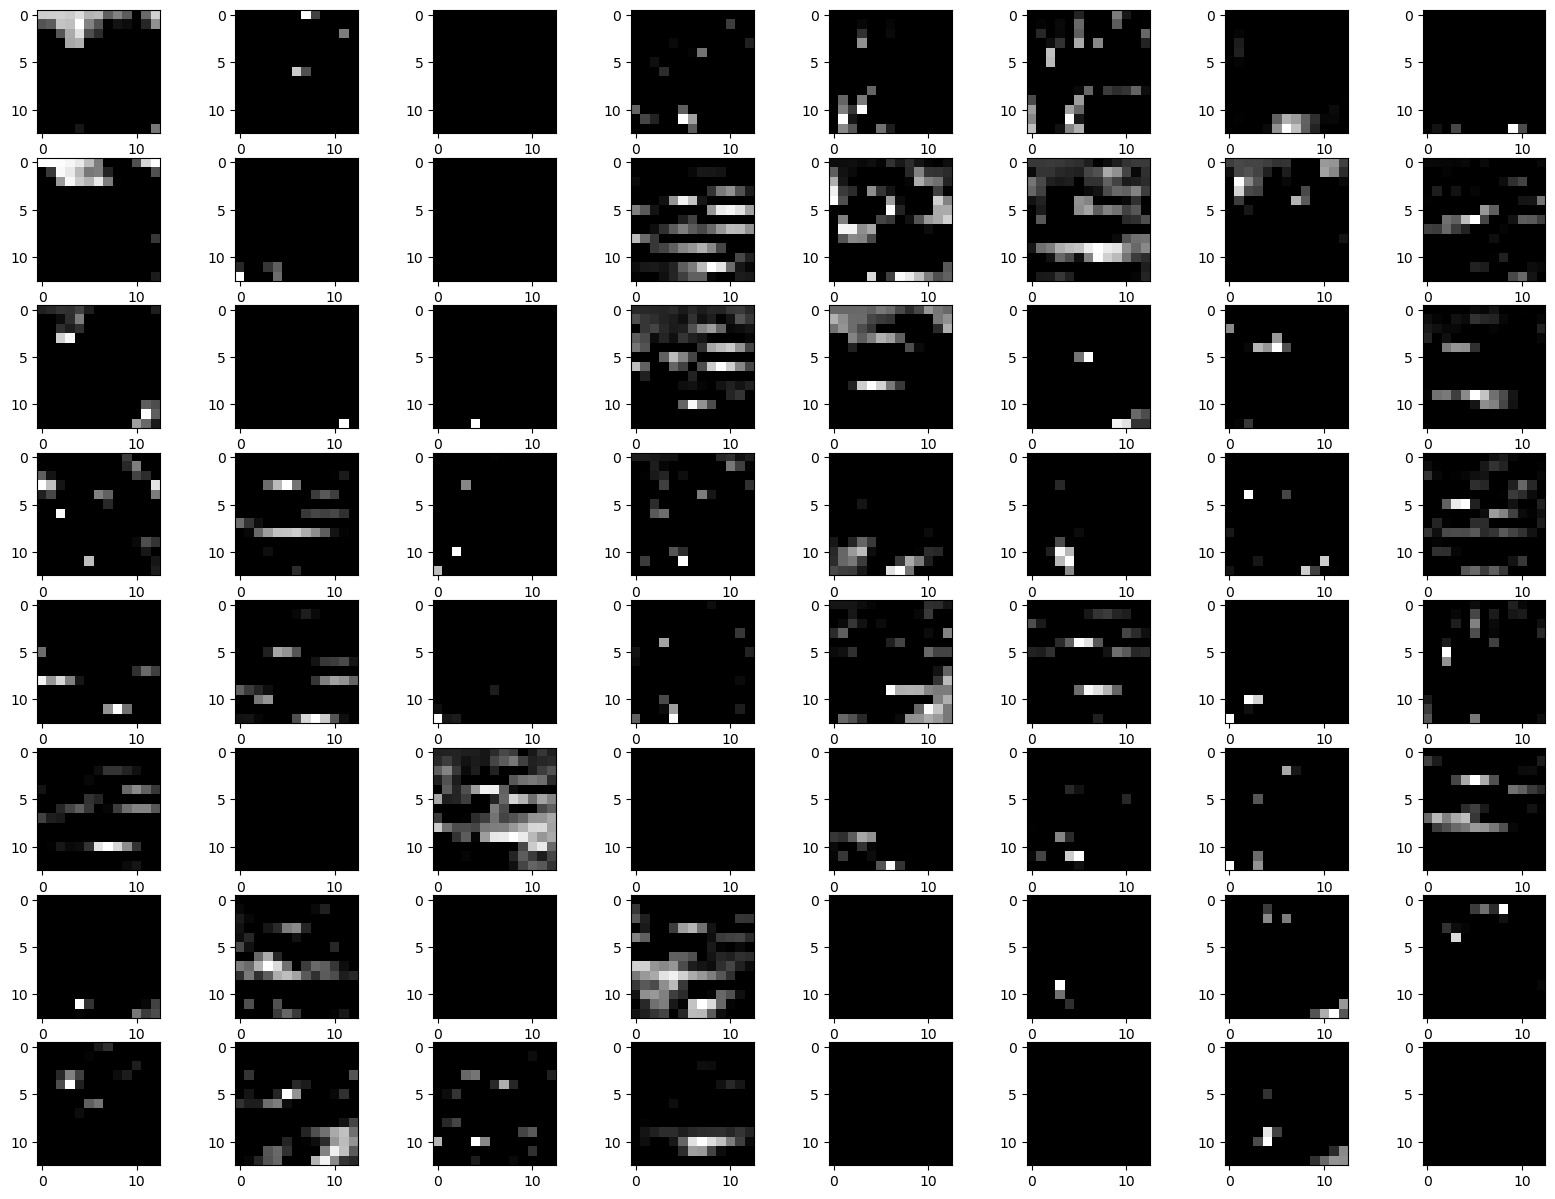

In [58]:
fig = pyplot.figure(figsize=(20,15))
for i in range(1,prediction2.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(prediction2[1,:,:,i-1] , cmap='gray')
    
pyplot.show()

In [59]:
model2 = Model(inputs=model.inputs , outputs=model.layers[4].output)
prediction2 = model2.predict(test_images)
prediction2.shape

313/313 [==============================] - 1s 3ms/step


(10000, 4, 4, 64)

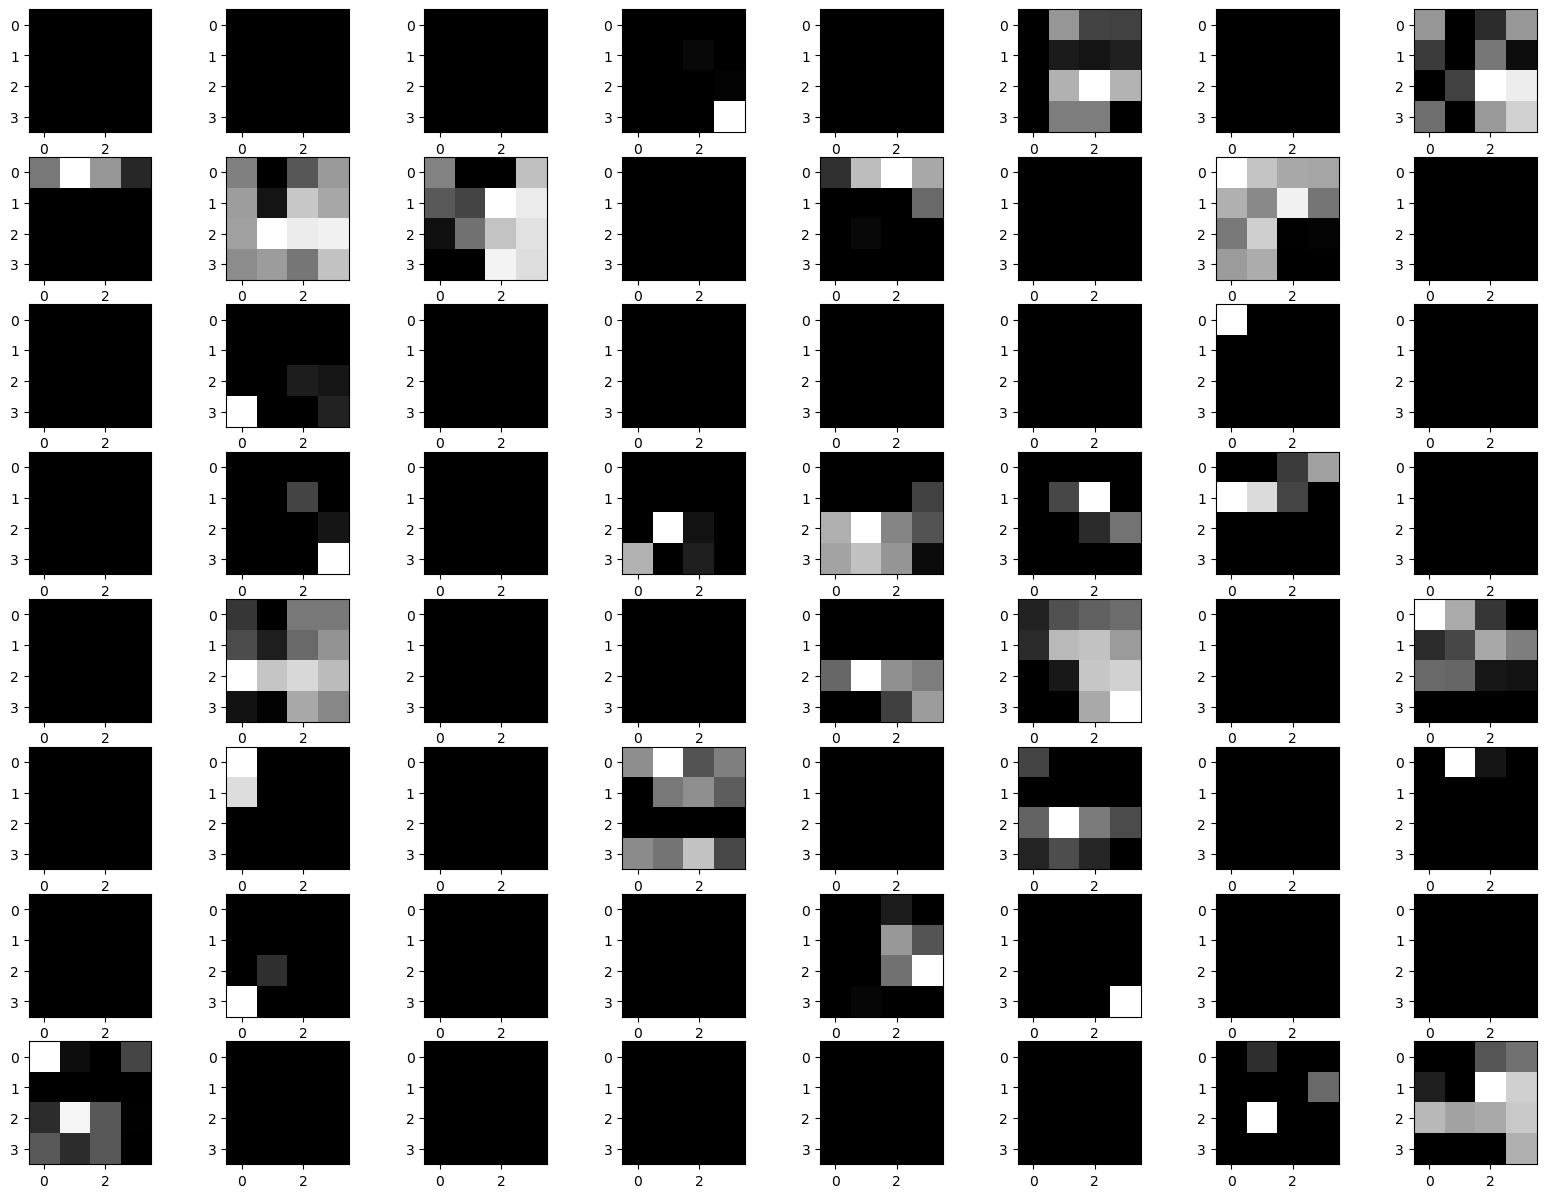

In [60]:
fig = pyplot.figure(figsize=(20,15))
for i in range(1,prediction2.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(prediction2[1,:,:,i-1] , cmap='gray')
    
pyplot.show()

Congratulations, you've fit and (sortof) explored your first CNN!